In [63]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf


In [64]:
df = pd.read_csv("Data/Data.csv")
df = df[["country", "commodity", "year", "loss_percentage", "activity", "food_supply_stage", "cause_of_loss"]]

def focus_on(country, commodity):
    new_df = df[df.country == country]
    new_df = new_df[new_df.commodity == commodity]
    return new_df

data = focus_on("Kenya", "Maize (corn)")
data = focus_on("Benin", "Maize (corn)")
data = data.reset_index()
data.sort_values(by=(["index"]), ascending=False, inplace=True)
data

,index,country,commodity,year,loss_percentage,activity,food_supply_stage,cause_of_loss
151,3072,Benin,Maize (corn),2000,6.42,"Drying, Harvesting",Harvest,NaN
150,3071,Benin,Maize (corn),2000,2.36,Transportation,Farm,NaN
149,3070,Benin,Maize (corn),2000,4.00,Drying,Farm,NaN
148,3069,Benin,Maize (corn),2000,3.05,Storage,Farm,NaN
147,3068,Benin,Maize (corn),2000,1.65,Transportation,Transport,NaN
...,...,...,...,...,...,...,...,...
4,2452,Benin,Maize (corn),2020,2.36,Transportation,Farm,NaN
3,2451,Benin,Maize (corn),2020,4.00,Drying,Farm,NaN
2,2450,Benin,Maize (corn),2020,6.42,"Drying, Harvesting",Harvest,NaN
1,2449,Benin,Maize (corn),2020,3.04,Storage,Farm,NaN


In [65]:
validate = data[["activity","food_supply_stage","loss_percentage"]].tail(3)
data.drop(data.tail(3).index,inplace=True)

In [66]:
for i in data.select_dtypes('object').columns:
    le = LabelEncoder().fit(data[i])
    data[i] = le.transform(data[i])
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]])
Y_data = Y_scaler.fit_transform(data[['loss_percentage']])

In [67]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y)

In [86]:
hist_window = 8
horizon = 3
TRAIN_SPLIT = 120
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [87]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.2        0.25       0.19859813]
 [0.8        0.         0.04049844]
 [0.         0.         0.10436137]
 [0.6        0.         0.0673676 ]
 [0.8        0.75       0.01285047]
 [0.4        0.         0.        ]
 [0.6        0.5        0.05179128]
 [1.         1.         0.64174455]]

 Target horizon

[[0.05179128]
 [0.10436137]
 [0.19859813]]


In [88]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [89]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
    ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 8, 400)           326400    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 8, 20)             8020      
                                                                 
 bidirectional_7 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 20)                6020      
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)               

In [90]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - 9s 49ms/step - loss: 0.0218 - val_loss: 0.0086
Epoch 2/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0188 - val_loss: 0.0144
Epoch 3/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0143 - val_loss: 0.0241
Epoch 4/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0088 - val_loss: 0.0199
Epoch 5/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0068 - val_loss: 0.0195
Epoch 6/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0049 - val_loss: 0.0194
Epoch 7/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0034 - val_loss: 0.0161
Epoch 8/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0028 - val_loss: 0.0172
Epoch 9/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0023 - val_loss: 0.0176
Epoch 10/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0019 - val_lo

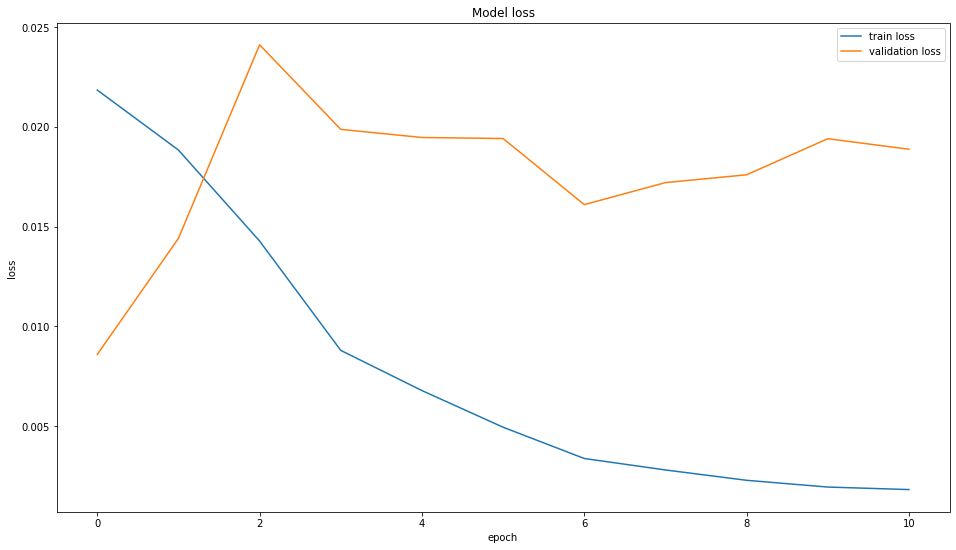

In [91]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [95]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

1/1 [==============================] - 1s 984ms/step


array([[3.2105322, 6.7554965, 1.4413449]], dtype=float32)

In [96]:

data_val

array([[0.25      , 0.33333333, 1.        ],
       [0.        , 0.        , 0.5254902 ],
       [1.        , 1.        , 0.06470588],
       [1.        , 0.        , 0.20392157],
       [0.5       , 0.        , 0.        ],
       [1.        , 1.        , 0.06470588],
       [1.        , 0.        , 0.20392157],
       [0.        , 0.        , 0.5254902 ]])

In [97]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [98]:
timeseries_evaluation_metrics_func(validate["loss_percentage"],pred_Inverse[0])

Evaluation metric results:-
MSE is : 8.522148381191485
MAE is : 2.711206485430399
RMSE is : 2.9192718923031964
MAPE is : 72.60720605297118
R2 is : -1.9740643609670396



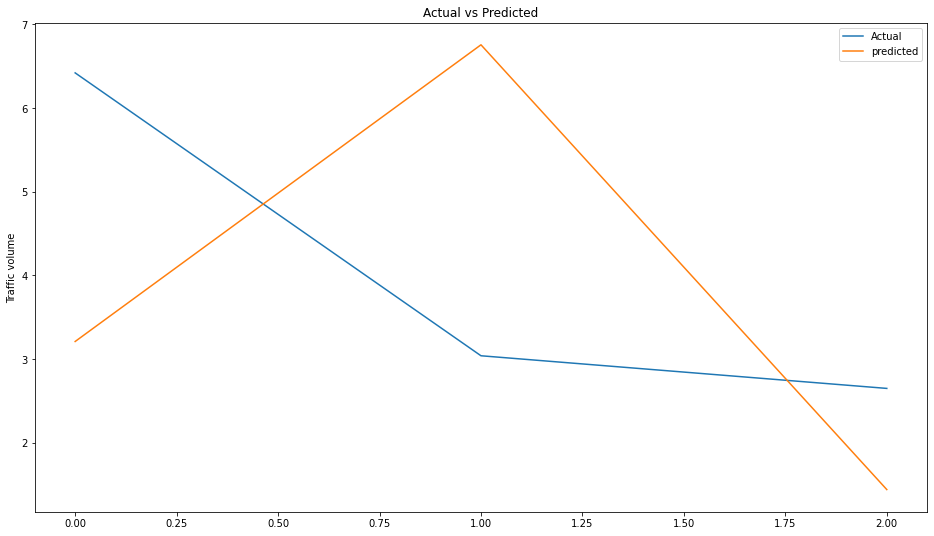

In [101]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['loss_percentage']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

In [104]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [105]:
validate["loss_percentage"]

2    6.42
1    3.04
0    2.65
Name: loss_percentage, dtype: float64

In [106]:
pred_Inverse[0]

array([3.2105322, 6.7554965, 1.4413449], dtype=float32)